In [2]:
import os
import pandas as pd
import numpy as np

import torch
from torch import nn
from tqdm import tqdm
import pylab
from torch.utils.data import Dataset, DataLoader

from fin_utils.metrics.pnl import pnl_from_positions
from fin_utils.candles.features import construct_features
from fin_utils.candles.loading import load_feather_dir
from fin_utils.candles.labels import construct_labels

from ml_utils import fix_random_seed, init_xavier_uniform
fix_random_seed(0)
from ml_utils.datasets import WindowedFeaturesLabelsDataset, WindowedBacktestDataset
from ml_utils.metrics import accuracy

from models.mlp import MLP

## Data Preperation
First, let's prepare the data for training.

**Note** that the entire code from the next cell was part of prior work performed by the folks that run the DeepFinance project and I am using it as part of my task. None of it is a contribution from my part

In [3]:
# 1) decide on coin list, load feathers and construct features
# coin_list = ['EURCHF']
# coin_list = ['AUDCAD', 'EURCHF']
# coin_list = ['AUDCAD', 'AUDCHF', 'AUDJPY', 'AUDNZD', 'AUDUSD', 'CADCHF', 'CADJPY', 'CHFJPY', 'EURAUD', 'EURCAD',
#              'EURCHF', 'EURDKK', 'EURGBP', 'EURJPY', 'EURNOK', 'EURNZD', 'EURSEK', 'EURUSD', 'GBPAUD', 'GBPCAD',
#              'GBPCHF', 'GBPJPY', 'GBPNZD', 'GBPUSD', 'NZDCAD', 'NZDCHF', 'NZDJPY', 'NZDUSD', 'SGDJPY', 'USDCAD',
#              'USDCHF', 'USDDKK', 'USDHKD', 'USDJPY', 'USDNOK', 'USDSEK', 'USDSGD']
# PATH_TO_FEATHER = '../data/Forex/'
# let's use crypto for now
coin_list = ['BTCUSDT', 'LTCBTC', 'ETHBTC']
PATH_TO_FEATHER = './data/Crypto/minute_binance' # change this to point to the data folder
index_col = 'date'
# RESAMPLE = '30T'
resample = '1H'

candle_dict = load_feather_dir(PATH_TO_FEATHER, pairs=coin_list, resample=resample,
                               n_workers=6, index_col=index_col)
assets = list(candle_dict.keys())

features = construct_features(candle_dict, train_end='2020', normalize=True,
                              feature_config=(
                                  # basic features
                                  dict(name='int_bar_changes', func_name='inter_bar_changes',
                                       columns=['close', 'high', 'low'],
                                       use_pct=True),
                                  # dict(name='int_bar_changes_10', func_name='inter_bar_changes',
                                  #      columns=['close', 'high', 'low'], use_pct=True,
                                  #      smoothing_window=10),
                                  # dict(func_name='hl_to_pclose'),
                                  # dict(func_name='next_return'),  # this is a cheat feature, to test we can learn
                              ))
#print(features)

# 2) decide on train/val/test split (train/val for simplicity for now)
train_start = '2000'
train_end = '2018'
val_start = '2019'
val_end = '2020'
train_features = {k: features[k][train_start:train_end] for k in features.keys()}
val_features = {k: features[k][val_start:val_end] for k in features.keys()}

#print(train_features)
#print(val_features)

# 3) setup classification targets
labels = construct_labels(candle_dict,
                          label_config=dict(name='oracle_labels',
                                            parameters=dict(target_profit=5e-3))
                          )
train_labels = {k: labels[k][train_start:train_end] for k in labels.keys()}
val_labels = {k: labels[k][val_start:val_end] for k in labels.keys()}
first_key = list(val_labels.keys())[0]
class_indices = val_labels[first_key].unique()
samples_per_class = pd.concat(val_labels).value_counts()
print(samples_per_class)
n_classes = len(class_indices)
print(n_classes)

# 4) Create data loaders
batch_size = 128
val_batch_size = 256
window = 5  # how many time steps to concatenate for each sample
n_features = train_features[first_key].shape[1] * window
step_size = 1  # stride of timeseries sampling

train_dataset = WindowedFeaturesLabelsDataset(train_features, train_labels, w=window, s=step_size)
val_dataset = WindowedFeaturesLabelsDataset(val_features, val_labels, w=window, s=step_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size)

1    26778
2    25854
dtype: int64
2


In [4]:
# Let's have a look on some training data
print(train_features['ethbtc'].to_numpy())

[[ 1.1853136   0.06850793 -0.1697123 ]
 [ 1.1853136   0.06850793 -0.1697123 ]
 [-2.2757843  -1.3243904  -0.025342  ]
 ...
 [ 0.04927521  0.89848125 -0.00661464]
 [ 0.33758694  0.5058673   0.00626452]
 [-0.291493   -0.13030432  0.00849401]]


## Convolutional Neural Network
Let's get started by working with CNNs. First, I am defining the NN interface (using a PyTorch model class) and afterwards I am training and testing it accordingly. For more info, please refer to the report that is part of my submission.

In [8]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels=1, cnn_channels=8, n_output=3, kernel_size=3, stride=1, padding='same'):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, cnn_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size, stride, padding)
        self.conv3 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size, stride, padding)

        self.pool = nn.MaxPool1d(2, stride=2)
        self.bn = nn.BatchNorm1d(in_channels)
        self.flatten = nn.Flatten()

        self.fc = nn.LazyLinear(n_output)

    def forward(self, x):
        x = self.bn(x)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)
        x = self.fc(x)

        return x

# Added for completeness, can be used for testing
class VGGLike(nn.Module):
    def __init__(self, in_channels=1, initial_out_channels=8, n_output=3, kernel_size=3, stride=1, padding='same'):
        super(VGGLike, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, initial_out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(initial_out_channels, 2 * initial_out_channels, kernel_size, stride, padding)
        self.conv3 = nn.Conv1d(2 * initial_out_channels, 4 * initial_out_channels, kernel_size, stride, padding)

        self.pool = nn.MaxPool1d(2, stride=2)
        self.bn = nn.BatchNorm1d(in_channels)
        self.flatten = nn.Flatten()

        self.fc = nn.LazyLinear(n_output)

    def forward(self, x):
        x = self.bn(x)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = self.flatten(x)
        x = self.fc(x)

        return x


In [6]:
# 5) setup a network
net = CNN(in_channels=1, cnn_channels=2, kernel_size=5)

device = 'cpu'
net.to(device)

n_epochs = 20
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

/Users/nicktzavidas/anaconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  2%|▏         | 7/295 [00:00<00:04, 68.33it/s, train_loss=1.05, train_acc=49]  


Epoch 1/20


  6%|▋         | 19/295 [00:00<00:01, 188.65it/s, train_loss=0.716, train_acc=56.2]


Epoch 2/20


  5%|▌         | 16/295 [00:00<00:01, 152.32it/s, train_loss=0.687, train_acc=57.9]


Epoch 3/20


  8%|▊         | 23/295 [00:00<00:01, 228.16it/s, train_loss=0.688, train_acc=58.2]


Epoch 4/20


  8%|▊         | 25/295 [00:00<00:01, 247.97it/s, train_loss=0.684, train_acc=58.1]


Epoch 5/20


  7%|▋         | 20/295 [00:00<00:01, 197.34it/s, train_loss=0.684, train_acc=58.8]


Epoch 6/20


  6%|▋         | 19/295 [00:00<00:01, 183.14it/s, train_loss=0.684, train_acc=58.9]


Epoch 7/20


  9%|▉         | 26/295 [00:00<00:01, 254.34it/s, train_loss=0.683, train_acc=58.9]


Epoch 8/20


  9%|▉         | 26/295 [00:00<00:01, 258.36it/s, train_loss=0.681, train_acc=60]  


Epoch 9/20


  8%|▊         | 25/295 [00:00<00:01, 243.67it/s, train_loss=0.68, train_acc=59.4] 


Epoch 10/20


  7%|▋         | 21/295 [00:00<00:01, 204.89it/s, train_loss=0.678, train_acc=60.5]


Epoch 11/20


  8%|▊         | 23/295 [00:00<00:01, 228.38it/s, train_loss=0.681, train_acc=58.9]


Epoch 12/20


  8%|▊         | 23/295 [00:00<00:01, 226.24it/s, train_loss=0.676, train_acc=60.5]


Epoch 13/20


  7%|▋         | 20/295 [00:00<00:01, 199.49it/s, train_loss=0.673, train_acc=60.9]


Epoch 14/20


  8%|▊         | 25/295 [00:00<00:01, 245.80it/s, train_loss=0.678, train_acc=60]  


Epoch 15/20


  8%|▊         | 24/295 [00:00<00:01, 237.01it/s, train_loss=0.684, train_acc=58]  


Epoch 16/20


  8%|▊         | 23/295 [00:00<00:01, 226.56it/s, train_loss=0.678, train_acc=59.8]


Epoch 17/20


  8%|▊         | 23/295 [00:00<00:01, 224.20it/s, train_loss=0.674, train_acc=60.5]


Epoch 18/20


  8%|▊         | 25/295 [00:00<00:01, 242.99it/s, train_loss=0.673, train_acc=61]  


Epoch 19/20


  7%|▋         | 22/295 [00:00<00:01, 219.67it/s, train_loss=0.68, train_acc=61]   


Epoch 20/20


100%|██████████| 206/206 [00:00<00:00, 281.87it/s, val_loss=0.677, val_acc=56.6]


ethbtc train PnL: 44.37966704865897
ethbtc val PnL: 30.0871511237863
btcusdt train PnL: 55.46332688581914
btcusdt val PnL: 39.710050617804754
ltcbtc train PnL: 46.86851039867464
ltcbtc val PnL: 44.28671178988799


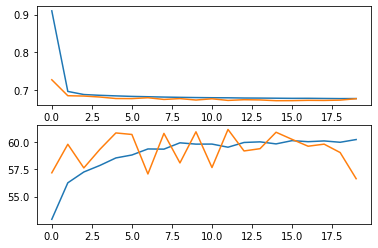

In [7]:
for epoch in range(n_epochs):
    train_running_loss = 0.
    train_running_acc = 0.
    train_batches = 0

    print(f"\nEpoch {epoch + 1}/{n_epochs}")

    tbar = tqdm(enumerate(train_loader), leave=True, position=0, total=len(train_loader))
    for idx, (train_input, train_target) in tbar:
        train_input = torch.unsqueeze(train_input, 1)
        train_input = train_input.to(device)
        train_target = train_target.to(device)

        optimizer.zero_grad()
        train_output = net(train_input)
        train_loss = loss(train_output, train_target)
        train_loss.backward()
        optimizer.step()

        train_batches += 1
        train_running_loss += train_loss.cpu().clone().item()
        train_running_acc += accuracy(train_output, train_target)

        tbar.set_postfix({"train_loss": train_running_loss / train_batches,
                          "train_acc": train_running_acc / train_batches})
    train_losses.append(train_running_loss / train_batches)
    train_accs.append(train_running_acc / train_batches)

    val_running_loss = 0.
    val_running_acc = 0.
    val_batches = 0

    vbar = tqdm(enumerate(val_loader), leave=True, position=0, total=len(val_loader))
    net.eval()

    for idx, (val_input, val_target) in vbar:
        with torch.no_grad():
            val_input = torch.unsqueeze(val_input, 1)
            val_input = val_input.to(device)
            val_target = val_target.to(device)

            val_output = net(val_input)
            val_loss = loss(val_output, val_target)

            val_batches += 1
            val_running_loss += val_loss.cpu().clone().item()
            val_running_acc += accuracy(val_output, val_target)

            vbar.set_postfix({"val_loss": val_running_loss / val_batches,
                              "val_acc": val_running_acc / val_batches})
    val_losses.append(val_running_loss / val_batches)
    val_accs.append(val_running_acc / val_batches)

commission = 2e-5
with torch.no_grad():
    for asset in assets:
        candle = candle_dict[asset]

        train_bt_dataset = WindowedBacktestDataset(train_features, w=window, s=step_size, asset=asset)
        train_predictions = pd.DataFrame(columns=['preds'], index=train_bt_dataset.timestamps[asset])
        asset_loader = DataLoader(train_bt_dataset, batch_size=200, drop_last=False)

        for idx, batch_asset_features in enumerate(asset_loader):
            train_batch_size = batch_asset_features.size(0)
            batch_asset_features = torch.unsqueeze(batch_asset_features, 1)
            batch_asset_features = batch_asset_features.to(device)
            batch_asset_output = net(batch_asset_features)
            _, batch_asset_predictions = batch_asset_output.max(1)
            batch_asset_predictions[batch_asset_predictions == 2] = -1
            train_predictions['preds'][idx * train_batch_size:(idx + 1) * train_batch_size] = batch_asset_predictions.cpu().numpy()
        train_predictions.index = train_bt_dataset.timestamps[asset]
        train_predictions = train_predictions['preds']
        pnl = pnl_from_positions(candle, train_predictions, commission=commission).sum()
        print(f"{asset} train PnL: {pnl}")

        val_bt_dataset = WindowedBacktestDataset(val_features, w=window, s=step_size, asset=asset)
        val_predictions = pd.DataFrame(columns=['preds'], index=val_bt_dataset.timestamps[asset])
        asset_loader = DataLoader(val_bt_dataset, batch_size=200, drop_last=False)

        for idx, batch_asset_features in enumerate(asset_loader):
            val_batch_size = batch_asset_features.size(0)
            batch_asset_features = torch.unsqueeze(batch_asset_features, 1)
            batch_asset_features = batch_asset_features.to(device)
            batch_asset_output = net(batch_asset_features)
            _, batch_asset_predictions = batch_asset_output.max(1)
            batch_asset_predictions[batch_asset_predictions == 2] = -1
            val_predictions['preds'][idx * val_batch_size:(idx + 1) * val_batch_size] = batch_asset_predictions.cpu().numpy()
        val_predictions.index = val_bt_dataset.timestamps[asset]
        val_predictions = val_predictions['preds']
        pnl = pnl_from_positions(candle, val_predictions, commission=commission).sum()
        print(f"{asset} val PnL: {pnl}")

fig, axs = pylab.subplots(2, 1)
axs[0].plot(train_losses)
axs[0].plot(val_losses)
axs[1].plot(train_accs)
axs[1].plot(val_accs)

pylab.show()


## Recurrent Neural Network
Next, I am working with RNNs archictures. I am operating in a fashion similar to the above section (first defining the model and trainging/testing it later). Like above, you can find more details about my work on the report.

In [5]:
from torch import nn

class RNNNet(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers, dropout, rnn_type='rnn'):
        super(RNNNet, self).__init__()

        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn_type = rnn_type

        if rnn_type not in [ 'rnn', 'lstm', 'gru' ]: # Invalid RNN type
            raise ValueError('Invalid RNN cell type')

        rnn_layer_params = {
            'input_size': n_input,
            'hidden_size': n_hidden,
            'num_layers': n_layers,
            'dropout': dropout,
            'batch_first': True
        }

        if rnn_type == 'rnn':
            self.rnn_layer = nn.RNN(**rnn_layer_params)
        elif rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(**rnn_layer_params)
        elif rnn_type == 'gru':
            self.rnn_layer = nn.GRU(**rnn_layer_params)

        self.fc = nn.Linear(n_hidden, n_output)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        x, hidden = self.rnn_layer(x, hidden)
        x = x.contiguous().view(-1, self.n_hidden)

        x = self.fc(x)
        
        # reshape into (batch_size, seq_length, output_size)
        x = x.view(batch_size, -1, self.n_output)
        # get last batch
        x = x[:, -1]
        
        return x, hidden


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if self.rnn_type == 'lstm':
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
            
        elif self.rnn_type == 'gru' or self.rnn_type == 'rnn':
            hidden = weight.new(self.n_layers, batch_size, self.n_hidden).zero_()

        return hidden



In [45]:
# 5) setup a network
type = 'rnn'

net = RNNNet(n_input=1, n_hidden=5, n_output=3, n_layers=4, dropout=0.2, rnn_type=type)
device = 'cpu'
net.to(device)

n_epochs = 20
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

  3%|▎         | 9/295 [00:00<00:03, 88.80it/s, train_loss=1.02, train_acc=49.1]


Epoch 1/20


  3%|▎         | 10/295 [00:00<00:03, 94.58it/s, train_loss=0.719, train_acc=50.8]


Epoch 2/20


  3%|▎         | 10/295 [00:00<00:03, 91.90it/s, train_loss=0.703, train_acc=50.2]


Epoch 3/20


  4%|▍         | 12/295 [00:00<00:02, 118.19it/s, train_loss=0.7, train_acc=48.3]  


Epoch 4/20


  4%|▍         | 13/295 [00:00<00:02, 124.29it/s, train_loss=0.698, train_acc=48.2]


Epoch 5/20


  4%|▍         | 13/295 [00:00<00:02, 114.97it/s, train_loss=0.696, train_acc=50.6]


Epoch 6/20


  4%|▍         | 13/295 [00:00<00:02, 124.24it/s, train_loss=0.695, train_acc=49.5]


Epoch 7/20


  4%|▍         | 13/295 [00:00<00:02, 127.05it/s, train_loss=0.695, train_acc=51.3]


Epoch 8/20


  4%|▍         | 12/295 [00:00<00:02, 116.86it/s, train_loss=0.694, train_acc=51.5]


Epoch 9/20


  4%|▍         | 12/295 [00:00<00:02, 115.55it/s, train_loss=0.695, train_acc=50.8]


Epoch 10/20


  4%|▍         | 12/295 [00:00<00:02, 112.31it/s, train_loss=0.694, train_acc=50.9]


Epoch 11/20


  4%|▎         | 11/295 [00:00<00:02, 109.33it/s, train_loss=0.693, train_acc=55]  


Epoch 12/20


  2%|▏         | 7/295 [00:00<00:04, 67.29it/s, train_loss=0.66, train_acc=62.1] 


Epoch 13/20


  4%|▍         | 12/295 [00:00<00:02, 114.68it/s, train_loss=0.665, train_acc=60.7]


Epoch 14/20


  5%|▍         | 14/295 [00:00<00:02, 130.32it/s, train_loss=0.658, train_acc=61.7]


Epoch 15/20


  3%|▎         | 9/295 [00:00<00:03, 85.98it/s, train_loss=0.649, train_acc=62.5]


Epoch 16/20


  4%|▎         | 11/295 [00:00<00:02, 102.82it/s, train_loss=0.652, train_acc=63.3]


Epoch 17/20


  4%|▍         | 12/295 [00:00<00:02, 116.12it/s, train_loss=0.653, train_acc=62.2]


Epoch 18/20


  4%|▎         | 11/295 [00:00<00:02, 108.51it/s, train_loss=0.662, train_acc=60.9]


Epoch 19/20


  4%|▍         | 13/295 [00:00<00:02, 129.82it/s, train_loss=0.645, train_acc=63.7]


Epoch 20/20


100%|██████████| 206/206 [00:01<00:00, 200.39it/s, val_loss=0.644, val_acc=63.1]


btcusdt train PnL: 68.62832259095107
btcusdt val PnL: 49.98939709972121
ethbtc train PnL: 54.73948054211772
ethbtc val PnL: 36.81893041998177
ltcbtc train PnL: 58.72167119006599
ltcbtc val PnL: 52.93040820774227


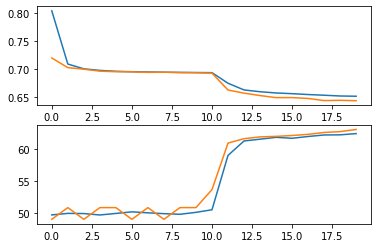

In [48]:
batch_size = 128

for epoch in range(n_epochs):
    train_running_loss = 0.
    train_running_acc = 0.
    train_batches = 0
    
    h = net.init_hidden(128)

    print(f"\nEpoch {epoch + 1}/{n_epochs}")

    tbar = tqdm(enumerate(train_loader), leave=True, position=0, total=len(train_loader))
    for idx, (train_input, train_target) in tbar:
        
        if train_input.size(0) != 128:
            continue
        
        train_input = torch.unsqueeze(train_input, 2)
        train_input = train_input.to(device)
        train_target = train_target.to(device)

        optimizer.zero_grad()
        train_output, h = net(train_input, h)
        
        if type == 'lstm':
            h = tuple([ each.data for each in h ]) # forget gradient history of hidden state
        else:
            h = h.data
        
        train_loss = loss(train_output, train_target)
        train_loss.backward()
        
        # clip the gradient
        nn.utils.clip_grad_norm_(net.parameters(), 5)
        
        optimizer.step()

        train_batches += 1
        train_running_loss += train_loss.cpu().clone().item()
        train_running_acc += accuracy(train_output, train_target)

        tbar.set_postfix({"train_loss": train_running_loss / train_batches,
                          "train_acc": train_running_acc / train_batches})
    train_losses.append(train_running_loss / train_batches)
    train_accs.append(train_running_acc / train_batches)

    val_running_loss = 0.
    val_running_acc = 0.
    val_batches = 0

    vbar = tqdm(enumerate(val_loader), leave=True, position=0, total=len(val_loader))
    net.eval()
    
    h = net.init_hidden(256)

    for idx, (val_input, val_target) in vbar:
        with torch.no_grad():
            if val_input.size(0) != 256:
                continue
            
            val_input = torch.unsqueeze(val_input, 2)
            val_input = val_input.to(device)
            val_target = val_target.to(device)
            
            val_output, h = net(val_input, h)
            
            # forget gradient history of hidden state
            if type == 'lstm':
                h = tuple([ each.data for each in h ]) 
            else:
                h = h.data

            val_loss = loss(val_output, val_target)

            val_batches += 1
            val_running_loss += val_loss.cpu().clone().item()
            val_running_acc += accuracy(val_output, val_target)

            vbar.set_postfix({"val_loss": val_running_loss / val_batches,
                              "val_acc": val_running_acc / val_batches})
    val_losses.append(val_running_loss / val_batches)
    val_accs.append(val_running_acc / val_batches)

commission = 2e-5
with torch.no_grad():
    for asset in assets:
        candle = candle_dict[asset]

        train_bt_dataset = WindowedBacktestDataset(train_features, w=window, s=step_size, asset=asset)
        train_predictions = pd.DataFrame(columns=['preds'], index=train_bt_dataset.timestamps[asset])
        asset_loader = DataLoader(train_bt_dataset, batch_size=200, drop_last=False)
        
        h = net.init_hidden(200)

        for idx, batch_asset_features in enumerate(asset_loader):
            if batch_asset_features.size(0) != 200:
                continue
            
            train_batch_size = batch_asset_features.size(0)
            batch_asset_features = torch.unsqueeze(batch_asset_features, 2)
            batch_asset_features = batch_asset_features.to(device)
            
            #batch_asset_output = net(batch_asset_features)
            batch_asset_output, h = net(batch_asset_features, h)
            
            # forget gradient history of hidden state
            if type == 'lstm':
                h = tuple([ each.data for each in h ]) 
            else:
                h = h.data
            
            _, batch_asset_predictions = batch_asset_output.max(1)
            batch_asset_predictions[batch_asset_predictions == 2] = -1
            train_predictions['preds'][idx * train_batch_size:(idx + 1) * train_batch_size] = batch_asset_predictions.cpu().numpy()
        train_predictions.index = train_bt_dataset.timestamps[asset]
        train_predictions = train_predictions['preds']
        pnl = pnl_from_positions(candle, train_predictions, commission=commission).sum()
        print(f"{asset} train PnL: {pnl}")
        

        val_bt_dataset = WindowedBacktestDataset(val_features, w=window, s=step_size, asset=asset)
        val_predictions = pd.DataFrame(columns=['preds'], index=val_bt_dataset.timestamps[asset])
        asset_loader = DataLoader(val_bt_dataset, batch_size=200, drop_last=False)
        
        h = net.init_hidden(200)

        for idx, batch_asset_features in enumerate(asset_loader):
            if batch_asset_features.size(0) != 200:
                continue
            
            val_batch_size = batch_asset_features.size(0)
            batch_asset_features = torch.unsqueeze(batch_asset_features, 2)
            batch_asset_features = batch_asset_features.to(device)
            
            #batch_asset_output = net(batch_asset_features)
            batch_asset_output, h = net(batch_asset_features, h)
            
            # forget gradient history of hidden state
            if type == 'lstm':
                h = tuple([ each.data for each in h ]) 
            else:
                h = h.data
            
            _, batch_asset_predictions = batch_asset_output.max(1)
            batch_asset_predictions[batch_asset_predictions == 2] = -1
            val_predictions['preds'][idx * val_batch_size:(idx + 1) * val_batch_size] = batch_asset_predictions.cpu().numpy()
        val_predictions.index = val_bt_dataset.timestamps[asset]
        val_predictions = val_predictions['preds']
        pnl = pnl_from_positions(candle, val_predictions, commission=commission).sum()
        print(f"{asset} val PnL: {pnl}")
        

fig, axs = pylab.subplots(2, 1)
axs[0].plot(train_losses)
axs[0].plot(val_losses)
axs[1].plot(train_accs)
axs[1].plot(val_accs)

pylab.show()
